In [1]:
import gzip
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# cd to code folder
%cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project
import mimic_utils as utils
import mimiciii_icu_trauma_patient_cohort as trauma_cohort

# Project Path
PROJECT_PATH = '/content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project'
# Data Path
# mimic original dataset path
DATASET_PATH = os.path.join(PROJECT_PATH, '1.4')
PREPROCESS_DATA_PATH = os.path.join(PROJECT_PATH, 'preprocess')

# environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3'  #this need to change according to your project_id in BigQuery

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project


# Spesis labeling

In [2]:
# ICD-9 codes for Angus criteria of sepsis
# To identify cases with severe sepsis,
# we selected all acute care hospitalizations with ICD-9-CM codes for both:
# (a) a bacterial or fungal infectious process AND
# (b) a diagnosis of acute organ dysfunction (Appendix 2).

angus_sepsis =  utils.run_query('''
                SELECT *
                FROM `physionet-data.mimiciii_derived.angus_sepsis`
                ''',
                PROJECT_ID)
angus_sepsis

,subject_id,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus
0,76682,167340,0,0,0,0,0
1,488,178969,0,0,0,0,0
2,3935,190483,0,0,0,0,0
3,6503,114310,0,0,0,0,0
4,8698,129757,0,0,0,0,0
...,...,...,...,...,...,...,...
58971,25736,137926,1,1,1,1,1
58972,26139,160907,1,1,1,1,1
58973,40728,138999,1,0,1,1,1
58974,65893,157656,1,0,1,1,1


In [3]:
# This code extracts explicit sepsis using ICD-9 diagnosis codes
# That is, the two codes 995.92 (severe sepsis) or 785.52 (septic shock)
# These codes are extremely specific to sepsis, but have very low sensitivity
# From Iwashyna et al. (vs. chart reviews): 100% PPV, 9.3% sens, 100% specificity

explicit_sepsis = utils.run_query('''
                SELECT *
                FROM `physionet-data.mimiciii_derived.explicit_sepsis`
                ''',
                PROJECT_ID)
explicit_sepsis

,subject_id,hadm_id,severe_sepsis,septic_shock,sepsis
0,2,163353,0,0,0
1,3,145834,0,0,0
2,4,185777,0,0,0
3,5,178980,0,0,0
4,6,107064,0,0,0
...,...,...,...,...,...
58971,99740,161687,1,1,1
58972,99756,172485,1,1,1
58973,99783,126090,1,1,1
58974,99912,189380,1,1,1


In [4]:
# ICD-9 codes for sepsis as validated by Martin et al.
# Greg S. Martin, David M. Mannino, Stephanie Eaton, and Marc Moss. The epidemiology of
# sepsis in the united states from 1979 through 2000. N Engl J Med, 348(16):1546–1554, Apr
# 2003. doi: 10.1056/NEJMoa022139. URL http://dx.doi.org/10.1056/NEJMoa022139.

martin_sepsis = utils.run_query('''
                SELECT *
                FROM `physionet-data.mimiciii_derived.martin_sepsis`
                ''',
                PROJECT_ID)
martin_sepsis

,subject_id,hadm_id,sepsis,organ_failure,respiratory,cardiovascular,renal,hepatic,hematologic,metabolic,neurologic
0,1207,109003,0,0,0,0,0,0,0,0,0
1,1314,161745,0,0,0,0,0,0,0,0,0
2,5901,160102,0,0,0,0,0,0,0,0,0
3,8016,175342,0,0,0,0,0,0,0,0,0
4,8072,104104,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
58971,17795,179589,1,1,1,0,1,0,1,0,1
58972,20900,162433,1,1,1,0,1,0,0,0,0
58973,26709,182764,1,1,1,1,1,0,0,0,0
58974,1369,186547,1,1,1,1,1,1,1,0,0


# From Mimic iii

In [5]:
Sepsis_Label_df = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH, "sepsis_label_final.xlsx"), index_col=0).rename({'label':'Posttraumatic_Sepsis'}, axis=1)
Sepsis_Label_df

,hadm_id,Posttraumatic_Sepsis
0,100011,1.0
1,100035,1.0
2,100132,0.0
3,100133,0.0
4,100138,1.0
...,...,...
1565,199877,0.0
1566,199909,0.0
1567,199931,1.0
1568,199962,0.0


In [6]:
#This table should contain 1 row per patient (with unique hadm_id)
Sepsis_Label_df = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH, "sepsis_label_final.xlsx"), index_col=0).rename({'label':'Posttraumatic_Sepsis'}, axis=1)
Sepsis_Label_df = Sepsis_Label_df.merge(angus_sepsis[['hadm_id', 'explicit_sepsis', 'angus']], how='left', on='hadm_id')
Sepsis_Label_df = Sepsis_Label_df.merge(martin_sepsis[['hadm_id', 'sepsis']], how='left', on='hadm_id').rename({'sepsis':'martin_sepsis'}, axis=1)
Sepsis_Label_df.set_index('hadm_id', inplace=True)
Sepsis_Label_df['label_count'] = Sepsis_Label_df.sum(axis=1)
Sepsis_Label_df

,Posttraumatic_Sepsis,explicit_sepsis,angus,martin_sepsis,label_count
hadm_id,,,,,
100011,1.0,0,1,0,2.0
100035,1.0,0,0,0,1.0
100132,0.0,0,1,0,1.0
100133,0.0,0,0,0,0.0
100138,1.0,0,1,1,3.0
...,...,...,...,...,...
199877,0.0,0,1,0,1.0
199909,0.0,0,0,0,0.0
199931,1.0,0,1,0,2.0


In [7]:
# num of sepsis label
Sepsis_Label_df.sum()

Posttraumatic_Sepsis     807.0
explicit_sepsis            136
angus                      844
martin_sepsis              279
label_count             2066.0
dtype: object

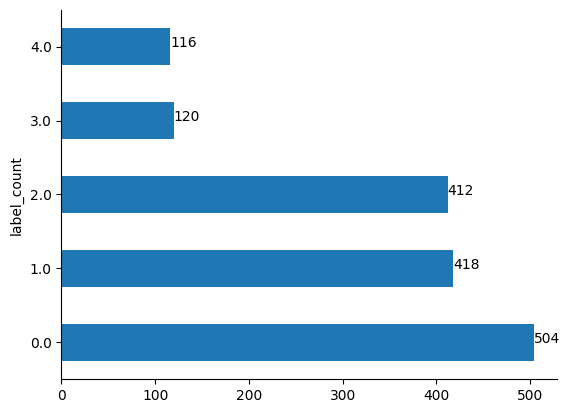

In [8]:
# label_count_bar = Sepsis_Label_df.groupby('label_count').count().rename({'Posttraumatic_Sepsis':'count'}, axis=1)[['count']]
label_count_bar = Sepsis_Label_df.groupby('label_count').size()

from matplotlib import pyplot as plt
import seaborn as sns
label_count_bar.plot(kind='barh',
                    #  color=sns.palettes.mpl_palette('Dark2')
                     )
plt.gca().spines[['top', 'right',]].set_visible(False)

for index, value in enumerate(label_count_bar):
    plt.text(value, index, str(value))

* 4 methods all agree on **620 samples**
> 504 negative samples  
> **116 positive** samples

* Posttraumatic_Sepsis(our) only (not overlapping with other 3 methods) on **229 samples**
>  19 negative samples  
> **210 positive** samples

* Posttraumatic_Sepsis(our) agree with some methods but not all **721 controversial samples**
>  240 negative samples  
> **481 positive** samples (FP samples??)

In [9]:
disagree_df = Sepsis_Label_df[~Sepsis_Label_df.label_count.isin([0, 4])]
# print
only_uw = pd.concat(
    [disagree_df[(disagree_df['label_count'] == 1) & (disagree_df.Posttraumatic_Sepsis==1)],  #210
     disagree_df[(disagree_df['label_count'] == 3) & (disagree_df.Posttraumatic_Sepsis==0)]], # 19
    axis=0)
print(only_uw.groupby('Posttraumatic_Sepsis').size())

controversial_df = disagree_df[~disagree_df.index.isin(only_uw.index)]
print(controversial_df.groupby('Posttraumatic_Sepsis').size())

Posttraumatic_Sepsis
0.0     19
1.0    210
dtype: int64
Posttraumatic_Sepsis
0.0    240
1.0    481
dtype: int64


## pair-wise comparision

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[[509 254]
 [217 590]]


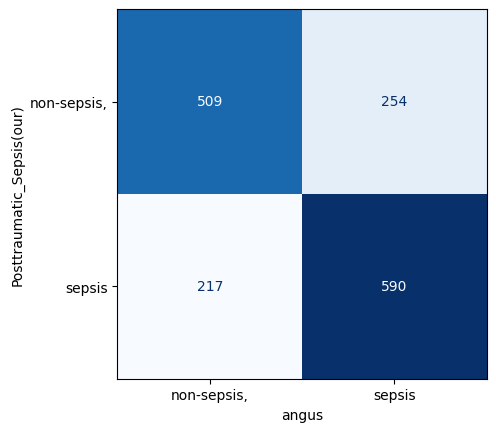

In [16]:
fig, ax = plt.subplots(1,1)

res = confusion_matrix(Sepsis_Label_df.Posttraumatic_Sepsis, Sepsis_Label_df.angus)
print(res)
disp = ConfusionMatrixDisplay(confusion_matrix=res,
                       display_labels=['non-sepsis,', 'sepsis'])
disp.plot(include_values=True, cmap="Blues", colorbar=False, ax=ax)
ax.set_ylabel('Posttraumatic_Sepsis(our)')
ax.set_xlabel('angus')
plt.show()

[[744  19]
 [690 117]]


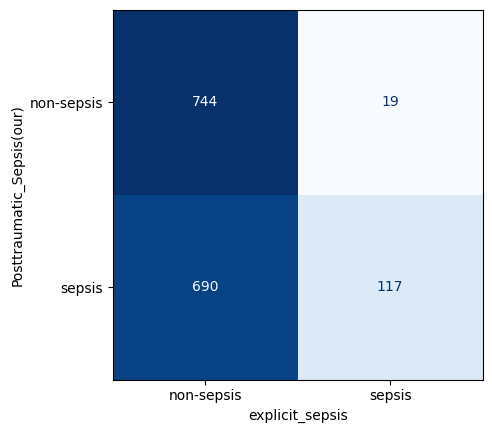

In [11]:
#
fig, ax = plt.subplots(1,1)

explicit_res = confusion_matrix(Sepsis_Label_df.Posttraumatic_Sepsis, Sepsis_Label_df.explicit_sepsis)
print(explicit_res)
disp = ConfusionMatrixDisplay(confusion_matrix=explicit_res,
                       display_labels=['non-sepsis', 'sepsis'])
disp.plot(include_values=True, cmap="Blues", colorbar=False, ax=ax)
ax.set_ylabel('Posttraumatic_Sepsis(our)')
ax.set_xlabel('explicit_sepsis')
plt.show()

[[707  56]
 [584 223]]


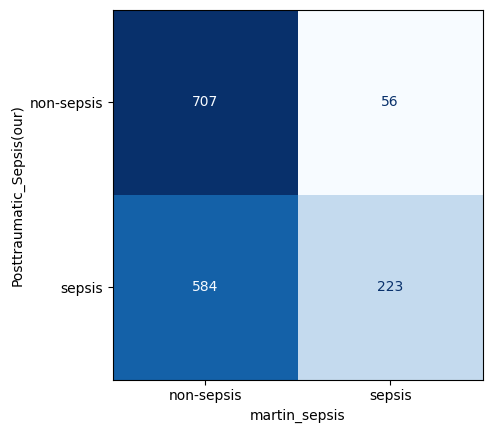

In [17]:
fig, ax = plt.subplots(1,1)

res = confusion_matrix(Sepsis_Label_df.Posttraumatic_Sepsis, Sepsis_Label_df.martin_sepsis)
print(res)
disp = ConfusionMatrixDisplay(confusion_matrix=res,
                       display_labels=['non-sepsis', 'sepsis'])
disp.plot(include_values=True, cmap="Blues", colorbar=False, ax=ax)
ax.set_ylabel('Posttraumatic_Sepsis(our)')
ax.set_xlabel('martin_sepsis')
plt.show()

# Microsoft Sepsis Labels

In [14]:
# %cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code
# !git clone https://github.com/microsoft/mimic_sepsis.git
%cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/mimic_sepsis
!pip3 install -r requirements.txt
# !cat requirements.txt
!ls

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/mimic_sepsis
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 35.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
CODE_OF_CONDUCT.md  preprocess.py  ReferenceFiles    SECURITY.md       SUPPORT.md
LICENSE		    README.md	   requirements.txt  sepsis_cohort.py


In [15]:
import fancyimpute
import numpy
import pandas
# import psycopg2
import pyprind
import scipy


ModuleNotFoundError: No module named 'fancyimpute'